# XGBoost 개요
- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
- 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능
- XGBoost는 병렬 CPU 환경에서 병력 학습이 가능해 기존 GBM보다 빠르게 학습을 완료
- XGBoost는 자체에 과적합 규제 기능으로 과적합에 좀 더 강한 내구성
- XBoost는 반복 수행 시마다 내부적으로 학습 dataset과 평가 dataset에 대한 교차 검증을 수행
- 지정된 반복 횟수가 아니라 교차 검증을 통해 평가 dataset의 평가 값이 최적화 되면 반복을 중간에 멈출 수 있는 조기 중단 기능


In [1]:
!pip install xgboost

## 파이썬 래퍼 XGBoost 하이퍼 파라미터
- 많은 종류의 하이퍼 파라미터가 있음
- GBM과 유사한 hyper parameter를 동일하게 가지고 있고, 조기 중단(Early Stopping), 과적합을 규제하기 위한 hyper parameter 등이 추가 됨
- 유형별로 일반 파라미터, 부스터 파라미터, 학습 태스크 파라미터로 구분
### 주요 일반 파라미터
- 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
- booster : gbtree(tree based model) 또는 gblinear(linear model) 선택, default는 gbtree
- silent : default는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정
- nthread : CPU의 실행 스레드 개수, default는 CPU의 전체 스레드를 다 사용하는 것
### 주요 부스터 파라미터
##### eta [default=0.3, alias: learning_rate]
- GBM의 학습률(learning rate)과 같은 파라미터
- 0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값
- 파이썬 래퍼 기반의 xgboost를 이용할 경우 default는 0.3
- 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체, default는 0.1, 보통은 0.01 ~ 0.2 사이의 값을 선호
#### max_depth [default=6]
- 트리 기반 알고리즘의 max_depth
- 0을 지정하면 깊이에 제한이 없다
- max_depth가 높으면 과적합 가능성이 높아짐
- 보통은 3~10 사이의 값을 적용
### 학습 태스크 파라미터 파라미터
#### objective
- 최솟값을 가져야할 손실 함수를 정의
- binary:logitic : 이진 분류일 때 적용
- multi:softmax : 다중 분류일 때 적용, label 클래스의 개수인 num_class parameter를 지정 필요
#### eval_metric
- 검증에 사용되는 함수를 정의
- defalut는 회귀인 경우는 rmse, 분류일 경우에는 error
- rmse : Root Mean Square Error
- error : Binary classification error rate (0.5 threshold)
- logloss : Negative log-likelihood


- 뛰어난 알고리즘일 수록 파라미터 튜닝의 필요성이 적음
- 파라미터 튜닝이 공수 대비 성능 효과가 높지 않은 경우가 대부분
- 튜닝은 피처의 수가 매우 많거나 피처 간 상관되는 정도가 많거나 데이터 세트에 따라 여러 가지 특성이 있을 수 있음


### 파이썬 Native XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

- 위스콘신 유방암 dataset은 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignment)인지 양성 종양(benign)인지를 분류한 dataset
- 양성 종양이 비교적 성장 속도가 느리고 전이되지 않는 것에 반해, 악성 종양은 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 전이되어 생명을 위협


In [11]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [15]:
# 양성malignant이 357개, 음성benign이 212개
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [16]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)


(455, 30) (114, 30)


In [17]:
#DMatrix는 numpy 입력 파라미터를 받아 만들어지는 XGBoost만의 전용 dataset
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [18]:
# hyper parameter는 주로 딕셔너리 형태로 입력
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
           }
# 반복 횟수
num_rounds = 400


In [19]:
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
# early_stopping_rounds=100 : 성능 개선이 안될때 조기 반족 중단 횟수
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , \
                      early_stopping_rounds=100, evals=wlist )


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08695
[177]	train-logloss:0.00695	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:0.00678	eval-logloss:0.08637
[188]	train-logloss:0.00676	eval-logloss:0.08630
[189]	train-logloss:0.00675	eval-logloss:0.08610
[190]	train-logloss:

In [20]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])


predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


get_clf_eval() 함수로 모델 성능을 평가


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [22]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


### 중요도를 막대그래프 plot_importance() API
- feature의 중요도를 막대그래프 형식으로 보여줌
- 기본 평가 지표로 f1 score를 기반
- 유의할 점은 xgboost 넘파이 기반의 feature 데이터로 학습 시 feature 명을 알 수 없음
- f0, f1과 같이 feature 순서별로 f자 뒤에 순서를 붙여서 축에 나열


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

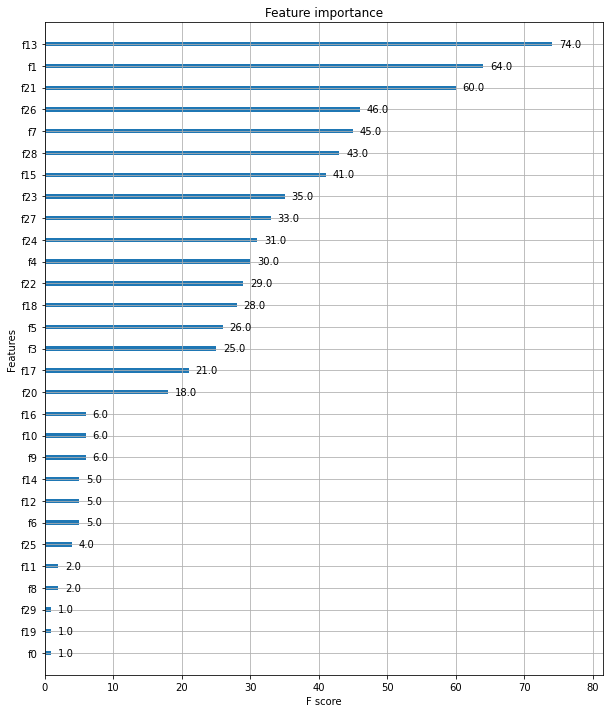

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)


### 사이킷런 Wrapper XGBoost 개요 및 적용
- 사이킷런 래퍼 XGBoost는 사이킷런의 기본 Estimator를 그대로 상속 만들었음
- fit()과 predict()만으로 학습과 예측이 가능
### 기존 xgboost 모듈 VS 사이킷런 XGBClassifier 파라미터
- eta -> learning_rate
- sub_sample -> subsample
- lambda -> reg_lambda , L2 Regularation 적용 값, 과적합 제어(클수록 과적합 감소)
- alpha -> reg_alpha, L1 Regularization 적용 값, 과적합 제어(클수록 과적합 감소)


In [26]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


In [27]:
get_clf_eval(y_test , w_preds, w_pred_proba)


오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


ㄴ 파이썬 래퍼 XGBoost와 동일한 평가 결과

In [28]:
#성능 평가를 수행
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
# 조기 중단 파라미터는 fit()에 입력
# 반복 횟수를 정의하는 early_stopping_rounds
# 조기 중단을 위한 평가 지표인 eval_metric
# 성능 평가를 수행할 dataset인 eval_set
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [29]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, 
                eval_metric="rmse", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)


[0]	validation_0-rmse:0.45859
[1]	validation_0-rmse:0.42202
[2]	validation_0-rmse:0.39062
[3]	validation_0-rmse:0.36249
[4]	validation_0-rmse:0.33831
[5]	validation_0-rmse:0.31649
[6]	validation_0-rmse:0.29785
[7]	validation_0-rmse:0.28198
[8]	validation_0-rmse:0.26712
[9]	validation_0-rmse:0.25544
[10]	validation_0-rmse:0.24448
[11]	validation_0-rmse:0.23655
[12]	validation_0-rmse:0.22815
[13]	validation_0-rmse:0.22207
[14]	validation_0-rmse:0.21520
[15]	validation_0-rmse:0.21135
[16]	validation_0-rmse:0.20549
[17]	validation_0-rmse:0.20136
[18]	validation_0-rmse:0.19793
[19]	validation_0-rmse:0.19482
[20]	validation_0-rmse:0.18907
[21]	validation_0-rmse:0.18881
[22]	validation_0-rmse:0.18580
[23]	validation_0-rmse:0.18314
[24]	validation_0-rmse:0.17901
[25]	validation_0-rmse:0.17812
[26]	validation_0-rmse:0.17530
[27]	validation_0-rmse:0.17503
[28]	validation_0-rmse:0.17162
[29]	validation_0-rmse:0.16990
[30]	validation_0-rmse:0.16982
[31]	validation_0-rmse:0.16952
[32]	validation_0-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

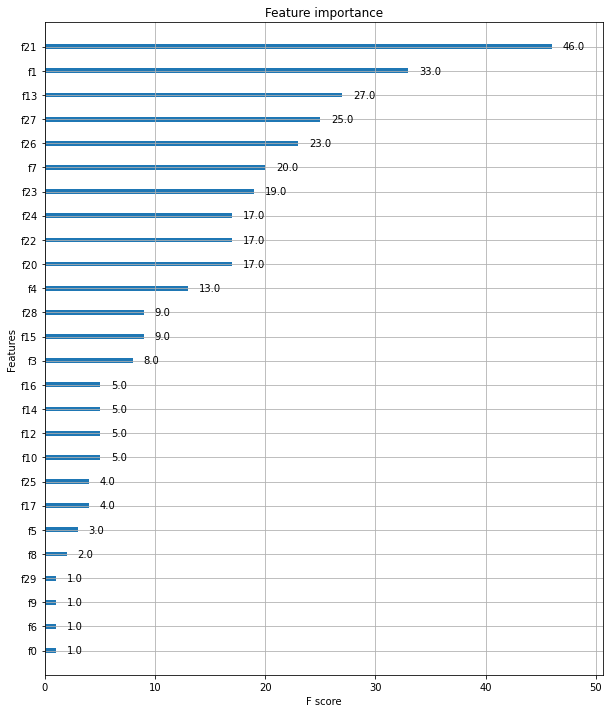

In [30]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)
